#### GNSS Remote Sensing and Positioning

# Understanding GNSS observations

**Original by: Hans van der Marel, Modified by: Sandra Verhagen, April 2024**

In this notebook you will learn how to read and use GNSS observation data stored in RINEX files in Python and do some simple plotting with this data. The reader and tools provided by the `pdrinex` module are build upon Pythons `numpy` and `pandas` and leverage the full strength of these modules to GNSS.

## Receiver Independent Exchange Format (RINEX)

RINEX is an acronym for Receiver INdependent EXchange Format. It contains raw observation data collected by the receiver, with for each **measurement epoch**, for each **satellite**, and for each **signal** a *pseudo-range*, *carrier-phase* and *signal-to-noise ratio* measurement. The RINEX data format is used to store the raw measurement data, it is *not* for storing positions or velocities, though the RINEX file has a header which contains the *approximate position* of the receiver amongst other data such as the *marker name*, *receiver type*, *antenna type*, *antenna offset*, *observer* and other meta data. RINEX data can be created for almost any receiver, either by the receiver itself, or by a converter program from raw, and often binary, data in the receivers proprietary format.   

GNSS data has several hierarchical dimensions

**measurement epochs** 
> **satellites** 
>> **signals**
>>> **pseudo-range, carrier-phase and signal-to-noise ratio measurement**

In RINEX the different signal and measurement types are combined into a single dimension called **observation types**.

### Measurement epochs

GNSS tracking data is sampled at regular intervals, the so-called **measurement epochs** and written to file. The measurement epoch is represented by a datetime string with a resolution of 0.1 ms in the receiver time frame. This resolution is necessary because the satellites travel at about 7 km/s, so a 0.1 ms resolution in time is equivalent to 0.7 mm resolution in the satellite positions. Note that for computing the satellite positions you need to take the travel time of the signal (some 70-90 ms) into account: at the time the signal is received at the receiver the satellites has already moved more than 500 m.

### RINEX satellite and system identifiers

Receivers tracks many **satellites** simultaneously. Almost all receivers sample the satellites at the same time, so a single measurement epoch contains data for several satellites. The satellites may belong to one system (e.g. GPS) or multiple systems (GPS, Glonass, Galileo, Beidou, etc.). This has no consequences for the data storage, though for data analysis the system must be known. The satellites are identifed by a three character string,

> [System Id][2digit PRN#]    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `G05`, `G12`, `E11`)

The first character is the identifier for the system, the other two characters is the number of the PRN code used by the satellite (or just the satellite number). System identifiers are

|System|Id|
|--|----|
|Global Positioning System GPS (USA)|G|
|Glonass (Russia)|R|
|Galileo (Europe)|E|
|Beidou (China)|C|
|Indian Regional Navigation Satellite System (IRNSS) |I|
|Quasi-Zenith Satellite System QZSS (Japan)|J|
|Satellite based augmentation system satellite (geostationary) |S|

### RINEX observation types

The receiver tracks several **signals**. Different signals may be transmitted on the same or different **frequencies**. For each signal the receiver tracks the code modulation and phase of the signal, resulting in measurements of **pseudo-range** [meters], **carrier-phase** [cycles] and **signal-to-noise ratio** [dB or dB-Hz]. The measurement for signal-to-noise ratio is often a **carrier-to-noise** measurement [dB-Hz]. The receiver may also track the Doppler shift [Hz], which can be given as an additional measurement. The type of signal and measurement are combined into **observation types**, which are characterized by a three letter abbreviation,

> [type][freq][attribute]   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `C1C`, `L2W`, `S1C`)

with

* [type] the measurement type: `C`=pseudo range [m], `L`=carrier phase [cycles], `D`=doppler [Hz],  `S`=signal strength [dB-Hz]
* [freq] the signal frequency code: `1`=L1/G1, `2`=L2/G2, `5`=L5/E5a, `6`=E6, `7`=E5b, `8`=E5 (E5a+E5b)
* [attribute] an attribute specifying the signal and tracking mode, e.g. `C` for standard code tracking, `W` for P-W tracking of the P-code signals, `X` for tracking both a pilot and data signal. 

Note that the receiver may track different signals on the same frequency, so it is not uncommon to find for example both a `_2W` and `_2X` for the same satellite (with `_` one of `C`, `L` or `S`).

The frequencies and signal that are tracked depend on the system. The signals that are tracked are listed in the RINEX file header for each system. Within a system, different generations of satellites exist, and older satellites may not provide all the signals that more recent satellites have. Furthermore, it depends on the receiver which signal types are actually tracked, and receiver manufacturers tend to make different choices.

### RINEX file naming and compression

A RINEX file contains multiple epochs, usually sampled at regular intervals. Common intervals are 30 sec for daily files and 1 sec for highrate files, but also other interval or fractions of seconds are possible. It is also common to sample at integers of seconds (then all 7 decimals of the second are zero). Data is stored often in daily files with 15 or 30 sec sample rate, hourly files with 10, 15 or 30 second sample rate, and/or high-rate data with 1 second sample rate in files with 15 minute intervals. The sampling rate is specified in the RINEX file header, but the interval and period is also reflected in the recommended RINEX file naming convention

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_30S_MO.rnx`) <br>
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO] .rnx.gz   
>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].crx.gz      

with 

* **name** [NNNN][##][CCC], defining the site (4 characters with letters and digits [NNNN]), station (2 digits [##]) and country (International country code [CCC]), 
* **start time**  [YYYYDDDHHMM], with year [YYYY], day of year [DDD], hour [HH] and minute [MM]
* nominal file **period** [##P], with two digits for the duration, followed by `D` for days, `H` for hours, or `M` for minutes
* **sample rate** [##S], with two digits for the sample period, followed by `S` for seconds (or `M`)

and [R] and identifier for receiver ([R]=`R`) or stream data ([R]=`S`), and [MO] the file type, with ([MO]=`MO`) for mixed observations (other possibilities are `GO`, `EO`, etc. for one system only observations.


The file extension is either `rnx` for uncompressed files, `rnx.gz` for `gzip` compressed files, and `crx.gz` for double compressed files, using first the so-called Hatanaka compression, followed by `gzip`. `gzip` compression is supported standard on most systems. For the Hatanaka decompression you have to used a small commandline tool `crx2rnx` to do the decompression (https://terras.gsi.go.jp/ja/crx2rnx.html).

For RINEX3 navigation files, which contains the broadcast satellite ephemerides data, a slightly different format is used

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [MN].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_MN.rnx`)
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [MN] .rnx.gz

Notice the different identifier for the file type, the absence of the sample rate field, and option for Hatanaka compression (crx).  

Tracking data for many GNSS receivers is available on the Internet as open access. For this demo we will use data from the Netherlands provided by the TU Delft from http://gnss1.tudelft.nl/dpga .  


For this Jupyter notebook to work, the Jupyter notebook should be in the same folder as the two modules. Import the modules using the following statements:

## Getting started

First thing to do is to import the `numpy` and `pandas` modules. Then, download the `pdrinex` module, put `pdrinex.py` into your working directory, and import the function we need from this module.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pdrinex import rnxReadObs, rnxPrintMetadata, rnxSelSys

You can use standard `help()` to get more information on each function. We do this for `rnxReadObs`, for the other functions it will become clear from the examples.

In [3]:
help(rnxReadObs)

Help on function rnxReadObs in module pdrinex:

rnxReadObs(rnxFilename: str, verbose: int = 0) -> (<class 'pandas.core.frame.DataFrame'>, <class 'dict'>, <class 'list'>)
    Read RINEX observation data from file.
    
    Parameters
    ----------
    rnxFilename : str
        RINEX observation filename
    verbose : int, default=0
        Verbosity level (0 is no output, 1 some, 2 more)
    
    Returns
    -------
    rnxDf : pandas.DataFrame
        Pandas multi index dataframe with the RINEX observations. The RINEX meta data, timestamps and other
        data are stored as attributes in the data frame (rnxDf.attrs).
        
    Raises
    ------
    ValueError
        If the file is not a RINEX observation file 
        If the RINEX observation file is other than a version 3 file (version 2 files not yet supported)
        If the time stamps are not strictly ascending or when there are duplicates
        If there are invalid satellite identifiers
    
    Notes
    -----
    Meta 

## Download RINEX data


First, we have to download some data. We are going to download a RINEX observation file for the IGS (International GNSS Service) station in Delft. The data is available from http://gnss1.tudelft.nl/dpga/rinex, and is stored in daily directories. For instance, data of 14 April 2021 can be found in http://gnss1.tudelft.nl/dpga/2021/104, where 104 is the day of year number. The name of the station is `DLF100NLD`, the compressed RINEX observation file for 14 April 2021 is called `DLF100NLD_R_20211040000_01D_30S_MO.crx.gz` (see the previous section).

**WHEN YOU HAVE ALREADY DOWNLOADED THE DATA, SKIP THE NEXT CELLS TO THE LAST CELL OF THIS SECTION,  TO SELECT JUST A FILENAME.**

To download the data we can use the `requests` module in Python. 

In [4]:
import requests
import os

#crxFilename = 'DLF100NLD_R_20171130000_01D_30S_MO.crx.gz'
#crxFilename = 'ZEGV00NLD_R_20211040000_01D_30S_MO.crx.gz'
crxFilename = 'DLF100NLD_R_20211040000_01D_30S_MO.crx.gz'

print('Compressed RINEX observation file:', crxFilename)

url='http://gnss1.tudelft.nl/dpga/rinex/' + crxFilename[12:16] + '/' + crxFilename[16:19] + '/' + crxFilename
print('Download URL:',url)

r = requests.get(url)
with open(crxFilename, 'wb') as f:
    f.write(r.content)
    
print('Status code (should be 200):',r.status_code)
print('Compressed file size:',os.path.getsize(crxFilename),' Bytes')

Compressed RINEX observation file: DLF100NLD_R_20211040000_01D_30S_MO.crx.gz
Download URL: http://gnss1.tudelft.nl/dpga/rinex/2021/104/DLF100NLD_R_20211040000_01D_30S_MO.crx.gz
Status code (should be 200): 200
Compressed file size: 2364102  Bytes


If this doesn't work for you, just download the file using your favorite browser and make sure to save it to your working directory.

The next step is to decompress the data. For this we are going to use `rnxUnpack` from the `rnxio` module. This module will download `crx2rnx` from https://terras.gsi.go.jp/ja/crx2rnx.html and use it together with `gzip` to uncompress the RINEX file. 

In [5]:
from rnxio import rnxUnpack

# rnxFilename = rnxUnpack(crxFilename)                  # for Windows users
rnxFilename = rnxUnpack(crxFilename, sys='darwin')   # for Mac users

print('Compressed file size:',"{:.2f}".format(os.path.getsize(crxFilename)/1024/1024),' Mb')
print('Uncompressed file size:',"{:.2f}".format(os.path.getsize(rnxFilename)/1024/1024),' Mb')
print('Compression ratio:',"{:.2f}".format(os.path.getsize(rnxFilename)/os.path.getsize(crxFilename)))

Using crx2rnx executable from RNXCMP_4.1.0_MacOSX10.14_gcc/bin/CRX2RNX
Compressed file size: 2.25  Mb
Uncompressed file size: 19.11  Mb
Compression ratio: 8.48


The compressed file size is about 2.3 Mb, compared to the uncompressed file size of 19.2 Mb. Generally, compressed RINEX files are 8-9 times smaller than the uncompressed files.

*The decompression module `rnxio` is still a bit experimental. If it doesn't work for you you can also download the RINEX file directly from Brightspace. If you have downloaded the data from Brightspace, or restart this notebook, and have the data already available, you can skip the previous steps and set RINEX filename directly in the next code segment.*

**CONTINUE HERE WHEN YOU HAVE ALREADY DOWNLOADED THE DATA...**

In [5]:
# Set RINEX file name (in case the data is already available on disk) - do not execute when you have downloaded the data

if not 'rnxFilename' in locals():
    #rnxFilename = 'DLF100NLD_R_20171130000_01D_30S_MO.rnx'
    #rnxFilename = 'ZEGV00NLD_R_20201190000_01D_30S_MO.rnx'
    rnxFilename = 'DLF100NLD_R_20211040000_01D_30S_MO.rnx'
    #rnxFilename = 'DLF100NLD_R_20221110000_01D_30S_MO.rnx'
    
print(rnxFilename)

DLF100NLD_R_20211040000_01D_30S_MO.rnx


## Read RINEX data 

The RINEX data is read using the `rnxReadObs` into a pandas **DataFrame**.  

In [6]:
rnxDf = rnxReadObs(rnxFilename, verbose=1)

RINEX type and version: OBS 3.04
Header fields: dict_keys(['RINEX VERSION / TYPE', 'PGM / RUN BY / DATE', 'COMMENT', 'MARKER NAME', 'MARKER NUMBER', 'OBSERVER / AGENCY', 'REC # / TYPE / VERS', 'ANT # / TYPE', 'ANTENNA: DELTA H/E/N', 'APPROX POSITION XYZ', 'SYS / # / OBS TYPES', 'SIGNAL STRENGTH UNIT', 'SYS / PHASE SHIFT', 'MARKER TYPE', 'GLONASS COD/PHS/BIS', 'GLONASS SLOT / FRQ #', '# OF SATELLITES', 'PRN / # OF OBS', 'INTERVAL', 'TIME OF FIRST OBS', 'TIME OF LAST OBS'])
Observation types:
C ['C2I', 'C7I', 'L2I', 'L7I', 'S2I', 'S7I']
E ['C1X', 'C5X', 'C7X', 'C8X', 'L1X', 'L5X', 'L7X', 'L8X', 'S1X', 'S5X', 'S7X', 'S8X']
G ['C1C', 'C2W', 'C2X', 'C5X', 'L1C', 'L2W', 'L2X', 'L5X', 'S1C', 'S2W', 'S2X', 'S5X']
J ['C1C', 'C1X', 'C1Z', 'C2X', 'C5X', 'C6L', 'L1C', 'L1X', 'L1Z', 'L2X', 'L5X', 'L6L', 'S1C', 'S1X', 'S1Z', 'S2X', 'S5X', 'S6L']
R ['C1C', 'C1P', 'C2C', 'C2P', 'C3X', 'L1C', 'L1P', 'L2C', 'L2P', 'L3X', 'S1C', 'S1P', 'S2C', 'S2P', 'S3X']
S ['C1C', 'L1C', 'S1C']
Maximum number of observ

Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language. The DataFrame, a fast and efficient object for data manipulation with integrated indexing, is what we use to store and manipulate the data. It inherits a lot of the functionality from `numpy` and `matplotlib` for plotting.  If you haven't worked with pandas before, please have a look at one of these resources

* https://pandas.pydata.org/docs/getting_started/index.html#
* https://pandas.pydata.org/docs/user_guide/index.html

For starters, to get some info on the data we can use pandas `info()` and/or `describe()` methods.

In [7]:
rnxDf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115987 entries, (Timestamp('2021-04-14 00:00:00'), 'C05') to (Timestamp('2021-04-14 23:59:30'), 'S36')
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       115987 non-null  float64
 1   1       102122 non-null  float64
 2   2       103217 non-null  float64
 3   3       79180 non-null   float64
 4   4       88342 non-null   float64
 5   5       98452 non-null   float64
 6   6       78188 non-null   float64
 7   7       66608 non-null   float64
 8   8       83608 non-null   float64
 9   9       62294 non-null   float64
 10  10      78248 non-null   float64
 11  11      69641 non-null   float64
 12  12      24458 non-null   float64
 13  13      24811 non-null   float64
 14  14      3573 non-null    float64
 15  15      1196 non-null    float64
 16  16      1207 non-null    float64
 17  17      396 non-null     float64
dtypes: float64(18)
memory usage: 16.3+ MB


Try out `rnxDf.describe()` yourself.

The meta data, mostly derived from the RINEX file header, is stored as attributes (dictionary) in `rnxDf.attrs`. To pretty print the meta data use the `rnxPrintMetadata` function provided by `pdrinex`

In [8]:
rnxPrintMetadata(rnxDf)

version :  3.04
rnxtype :  OBS
systems :  M
marker :  DLF1 (13502M009)
rectype :  TRIMBLE NETR9
anttype :  LEIAR25.R3      LEIT
interval :  30.0
timerange :  (Timestamp('2021-04-14 00:00:00'), Timestamp('2021-04-14 23:59:30'))
timesystem :  GPS
position :  (3924698.1158, 301124.8036, 5001904.9952)
antoffset :  (0.0, 0.0, 0.0)
obsTypes : 
    C : ['C2I', 'C7I', 'L2I', 'L7I', 'S2I', 'S7I']
    E : ['C1X', 'C5X', 'C7X', 'C8X', 'L1X', 'L5X', 'L7X', 'L8X', 'S1X', 'S5X', 'S7X', 'S8X']
    G : ['C1C', 'C2W', 'C2X', 'C5X', 'L1C', 'L2W', 'L2X', 'L5X', 'S1C', 'S2W', 'S2X', 'S5X']
    J : ['C1C', 'C1X', 'C1Z', 'C2X', 'C5X', 'C6L', 'L1C', 'L1X', 'L1Z', 'L2X', 'L5X', 'L6L', 'S1C', 'S1X', 'S1Z', 'S2X', 'S5X', 'S6L']
    R : ['C1C', 'C1P', 'C2C', 'C2P', 'C3X', 'L1C', 'L1P', 'L2C', 'L2P', 'L3X', 'S1C', 'S1P', 'S2C', 'S2P', 'S3X']
    S : ['C1C', 'L1C', 'S1C']
maxTypes :  18
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  2880
expected :  2880
missing :  0
epochTimestamps :  [Timestamp('

You can also use `print(rnxDf.attrs`), but this tends to give a lot output and is not very practical. To retrieve specific attributes you can use syntax `value = rnxDf.attrs['key']`. For example, to print the observation types, do

In [9]:
print(rnxDf.attrs['obsTypes'])

{'C': ['C2I', 'C7I', 'L2I', 'L7I', 'S2I', 'S7I'], 'E': ['C1X', 'C5X', 'C7X', 'C8X', 'L1X', 'L5X', 'L7X', 'L8X', 'S1X', 'S5X', 'S7X', 'S8X'], 'G': ['C1C', 'C2W', 'C2X', 'C5X', 'L1C', 'L2W', 'L2X', 'L5X', 'S1C', 'S2W', 'S2X', 'S5X'], 'J': ['C1C', 'C1X', 'C1Z', 'C2X', 'C5X', 'C6L', 'L1C', 'L1X', 'L1Z', 'L2X', 'L5X', 'L6L', 'S1C', 'S1X', 'S1Z', 'S2X', 'S5X', 'S6L'], 'R': ['C1C', 'C1P', 'C2C', 'C2P', 'C3X', 'L1C', 'L1P', 'L2C', 'L2P', 'L3X', 'S1C', 'S1P', 'S2C', 'S2P', 'S3X'], 'S': ['C1C', 'L1C', 'S1C']}


## Understanding what is in the pdrinex DataFrame

To see what is inside of a DataFrame can type the variable name, or use the `print()` or `head()` functions of Python. Note that the output of `print()` is slightly different than from typing the variable name

In [10]:
rnxDf

0             1             2   \
TimeStamp           SatId                                             
2021-04-14 00:00:00 C05    4.032859e+07  4.032858e+07  2.100016e+08   
                    C09    3.942533e+07  3.942532e+07  2.052981e+08   
                    C16    4.166828e+07  4.166828e+07  2.169777e+08   
                    C23    2.728473e+07           NaN  1.420788e+08   
                    C24    2.509502e+07           NaN  1.306764e+08   
...                                 ...           ...           ...   
2021-04-14 23:59:30 R16    2.387548e+07  2.387547e+07  2.387548e+07   
                    R20    2.355883e+07  2.355883e+07  2.355884e+07   
                    R21    2.016710e+07  2.016710e+07  2.016711e+07   
                    R22    2.083312e+07  2.083312e+07  2.083312e+07   
                    S36    3.856476e+07  2.026592e+08  4.400000e+01   

                                     3             4             5   \
TimeStamp           SatId                                             
2021-04-14 00:00:00 C05    1.623865e+08  3.650000e+01  3.790000e+01   
                    C09    1.587495e+08  4.140000e+01  4.410000e+01   
                    C16    1.677809e+08  3.700000e+01  3.420000e+01   
                    C23             NaN  3.970000e+01           NaN   
                    C24             NaN  4.720000e+01           NaN   
...                                 ...           ...           ...   
2021-04-14 23:59:30 R16    2.387548e+07           NaN  1.275385e+08   
                    R20    2.355883e+07           NaN  1.259797e+08   
                    R21    2.016711e+07  2.016710e+07  1.079183e+08   
                    R22    2.083312e+07           NaN  1.112086e+08   
                    S36             NaN           NaN           NaN   

                                     6             7             8   \
TimeStamp           SatId                                             
2021-04-14 00:00:00 C05             NaN           NaN           NaN   
                    C09             NaN           NaN           NaN   
                    C16             NaN           NaN           NaN   
                    C23             NaN           NaN           NaN   
                    C24             NaN           NaN           NaN   
...                                 ...           ...           ...   
2021-04-14 23:59:30 R16    1.275387e+08  9.919661e+07  9.919662e+07   
                    R20    1.259798e+08  9.798421e+07  9.798422e+07   
                    R21    1.079184e+08  8.393644e+07  8.393644e+07   
                    R22    1.112088e+08  8.649555e+07  8.649559e+07   
                    S36             NaN           NaN           NaN   

                                     9     10    11    12    13    14  15  16  \
TimeStamp           SatId                                                       
2021-04-14 00:00:00 C05             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
                    C09             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
                    C16             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
                    C23             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
                    C24             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
...                                 ...   ...   ...   ...   ...   ...  ..  ..   
2021-04-14 23:59:30 R16             NaN  40.2  40.1  34.7  33.4   NaN NaN NaN   
                    R20             NaN  33.7  32.9  38.5  38.0   NaN NaN NaN   
                    R21    8.086051e+07  51.4  49.9  47.9  46.6  51.0 NaN NaN   
                    R22             NaN  38.3  37.3  34.1  32.9   NaN NaN NaN   
                    S36             NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   

                           17  
TimeStamp           SatId      
2021-04-14 00:00:00 C05   NaN  
                    C09   NaN  
                    C16   NaN  
                    C23   NaN  
                   

The structure is very similar to how the data is stored in the RINEX file. 

Each row contains the observations for a single satellite at a specific measurement epoch. At a single measurement epochs, multiple satellites are observed. Therefore, for the rows a double index is used. The first index is the measurement epoch and is called *TimeStamp*, the second index is the satellite id and is called *SatId*.

The columns are named `0, 1, 2 ...`, each representing a different observation type. We used abstract column names because we cannot yet associate each column with a specific observation type, as the observation types are different for each system, given in the attribute `rnxDf.attrs['obsTypes']`. 

Furthermore, there are a lot of large values, not surprisingly since the satellites are at 20,000 km altitude. But there are also `NaN` when there are no measurements, which happens especially for the columns to the right. This is also not a surprise, considering that we have different number of observation types for each system.

Since the number and type of observations are different for each system, and each column of `rnxDf` can contains different observation types (though the same for each system), it makes sense to do our analysis system by system.

The `pdrinex` module provides very convenient functions for selecting data from one system or one satellite.

## Selecting data for a single system

To select data for a single system, e.g. GPS, use the `rnxSelSys()` function.

In [11]:
gpsDf_stacked = rnxSelSys(rnxDf,'G')
gpsDf_stacked

ObsType                             C1C           C2W           C2X  \
TimeStamp           SatId                                             
2021-04-14 00:00:00 G01    2.544193e+07  2.544194e+07  2.544194e+07   
                    G02    2.392986e+07  2.392986e+07           NaN   
                    G03    2.210712e+07  2.210713e+07  2.210713e+07   
                    G04    2.062062e+07  2.062062e+07  2.062062e+07   
                    G06    2.098952e+07  2.098952e+07  2.098952e+07   
...                                 ...           ...           ...   
2021-04-14 23:59:30 G17    2.432118e+07  2.432119e+07  2.432119e+07   
                    G19    2.325944e+07  2.325944e+07           NaN   
                    G22    2.467135e+07  2.467135e+07           NaN   
                    G26    2.522174e+07  2.522175e+07  2.522175e+07   
                    G31    2.493629e+07  2.493629e+07  2.493629e+07   

ObsType                             C5X           L1C           L2W  \
TimeStamp           SatId                                             
2021-04-14 00:00:00 G01    2.544194e+07  1.336983e+08  1.041805e+08   
                    G02             NaN  1.257523e+08  9.798880e+07   
                    G03    2.210713e+07  1.161738e+08  9.052507e+07   
                    G04    2.062062e+07  1.083621e+08  8.443806e+07   
                    G06    2.098952e+07  1.103006e+08  8.594862e+07   
...                                 ...           ...           ...   
2021-04-14 23:59:30 G17             NaN  1.278087e+08  9.959121e+07   
                    G19             NaN  1.222292e+08  9.524354e+07   
                    G22             NaN  1.296489e+08  1.010251e+08   
                    G26    2.522175e+07  1.325411e+08  1.032788e+08   
                    G31             NaN  1.310411e+08  1.021100e+08   

ObsType                             L2X           L5X   S1C   S2W   S2X   S5X  
TimeStamp           SatId                                                      
2021-04-14 00:00:00 G01    1.041805e+08  9.983969e+07  36.9  29.4  35.1  43.7  
                    G02             NaN           NaN  46.4  31.8   NaN   NaN  
                    G03    9.052506e+07  8.675319e+07  47.9  48.2  47.2  52.4  
                    G04    8.443805e+07  8.091981e+07  46.6  39.4  51.1  55.4  
                    G06    8.594861e+07  8.236741e+07  49.5  40.4  49.5  54.3  
...                                 ...           ...   ...   ...   ...   ...  
2021-04-14 23:59:30 G17    9.959122e+07           NaN  40.9  35.9  37.9   NaN  
                    G19             NaN           NaN  43.0  31.4   NaN   NaN  
                    G22             NaN           NaN  42.6  25.8   NaN   NaN  
                    G26    1.032788e+08  9.897555e+07  38.4  30.4  36.0  39.6  
                    G31    1.021100e+08           NaN  40.5  34.9  37.3   NaN  

[34068 rows x 12 columns]

As you can see, the column numbers have been replaced by appropriate observation types. 

There are still some `NaN`'s in the data, this is because there are several generations of GPS satellites, and only newer generations provide the so-called modernized signals. 

A little more worrying is that this data is not easy to plot. If you try, you may get unexpected results. This is because of the multi-index in the rows. 

To facilitate plotting it is wise to unstack the data, this can be done in `rnxSelSys` by giving the optional parameter `unstack=True`

In [12]:
gpsDf = rnxSelSys(rnxDf, 'G', unstack=True)
gpsDf

SatId                         G01                                            \
ObsType                       C1C           C2W           C2X           C5X   
TimeStamp                                                                     
2021-04-14 00:00:00  2.544193e+07  2.544194e+07  2.544194e+07  2.544194e+07   
2021-04-14 00:00:30  2.546437e+07  2.546438e+07  2.546438e+07  2.546437e+07   
2021-04-14 00:01:00  2.548680e+07  2.548681e+07  2.548681e+07  2.548681e+07   
2021-04-14 00:01:30  2.550923e+07  2.550924e+07  2.550924e+07  2.550924e+07   
2021-04-14 00:02:00  2.553166e+07  2.553166e+07  2.553166e+07  2.553166e+07   
...                           ...           ...           ...           ...   
2021-04-14 23:57:30  2.551270e+07  2.551271e+07  2.551271e+07  2.551271e+07   
2021-04-14 23:58:00  2.553512e+07  2.553513e+07  2.553513e+07  2.553513e+07   
2021-04-14 23:58:30  2.555755e+07  2.555756e+07  2.555756e+07  2.555756e+07   
2021-04-14 23:59:00  2.557997e+07  2.557998e+07  2.557998e+07  2.557998e+07   
2021-04-14 23:59:30  2.560239e+07  2.560240e+07  2.560240e+07  2.560240e+07   

SatId                                                                        \
ObsType                       L1C           L2W           L2X           L5X   
TimeStamp                                                                     
2021-04-14 00:00:00  1.336983e+08  1.041805e+08  1.041805e+08  9.983969e+07   
2021-04-14 00:00:30  1.338162e+08  1.042724e+08  1.042724e+08  9.992772e+07   
2021-04-14 00:01:00  1.339341e+08  1.043643e+08  1.043643e+08  1.000157e+08   
2021-04-14 00:01:30  1.340519e+08  1.044561e+08  1.044561e+08  1.001038e+08   
2021-04-14 00:02:00  1.341698e+08  1.045479e+08  1.045479e+08  1.001918e+08   
...                           ...           ...           ...           ...   
2021-04-14 23:57:30  1.340702e+08  1.044703e+08  1.044703e+08  1.001174e+08   
2021-04-14 23:58:00  1.341880e+08  1.045622e+08  1.045622e+08  1.002054e+08   
2021-04-14 23:58:30  1.343059e+08  1.046540e+08  1.046540e+08  1.002934e+08   
2021-04-14 23:59:00  1.344237e+08  1.047458e+08  1.047458e+08  1.003814e+08   
2021-04-14 23:59:30  1.345415e+08  1.048376e+08  1.048376e+08  1.004694e+08   

SatId                            ... G32                                      
ObsType               S1C   S2W  ... C2X C5X L1C L2W L2X L5X S1C S2W S2X S5X  
TimeStamp                        ...                                          
2021-04-14 00:00:00  36.9  29.4  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 00:00:30  36.9  29.8  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 00:01:00  36.2  29.9  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 00:01:30  36.9  29.1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 00:02:00  36.0  29.9  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                   ...   ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2021-04-14 23:57:30  35.2  29.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 23:58:00  35.0  28.5  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 23:58:30  35.7  27.4  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 23:59:00  35.4  28.9  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-04-14 23:59:30  35.8  28.7  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[2880 rows x 303 columns]

The columns are now a combination of *SatId* and *ObsType*, using a multi index. The rows are indexed by the timestamps. 

Unstacking the data eliminates also any unobserved observation type, but also introduces new `NaN`'s at timestamps where GPS satellites are unobserved. Unstacking the data requires about twice the storage, as we can see from `info()`.

In [13]:
gpsDf_stacked.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34068 entries, (Timestamp('2021-04-14 00:00:00'), 'G01') to (Timestamp('2021-04-14 23:59:30'), 'G31')
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1C     34068 non-null  float64
 1   C2W     33968 non-null  float64
 2   C2X     25164 non-null  float64
 3   C5X     17397 non-null  float64
 4   L1C     34050 non-null  float64
 5   L2W     33959 non-null  float64
 6   L2X     25164 non-null  float64
 7   L5X     17397 non-null  float64
 8   S1C     34068 non-null  float64
 9   S2W     33968 non-null  float64
 10  S2X     25164 non-null  float64
 11  S5X     17397 non-null  float64
dtypes: float64(12)
memory usage: 3.2+ MB


In [14]:
gpsDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2880 entries, 2021-04-14 00:00:00 to 2021-04-14 23:59:30
Columns: 303 entries, ('G01', 'C1C') to ('G32', 'S5X')
dtypes: float64(303)
memory usage: 6.7 MB


## Part 1: Selecting satellites, observation types and plotting

Plotting the data is easy, but you have to be selective in the amount of data to plot. In this section we explain how to select one or more satellites, and/or one or more observations types, and how to plot these selections.

Simple selections are fairly intuitive, but more advanced selections require the `.loc()` or `.iloc()` method and to specify an `axis` to work on. 

We let the examples speak for themselves.

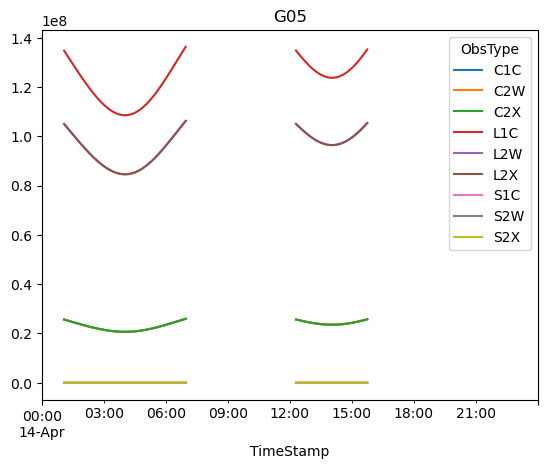

In [15]:
ax=gpsDf['G05'].plot()
ax.set_title('G05');

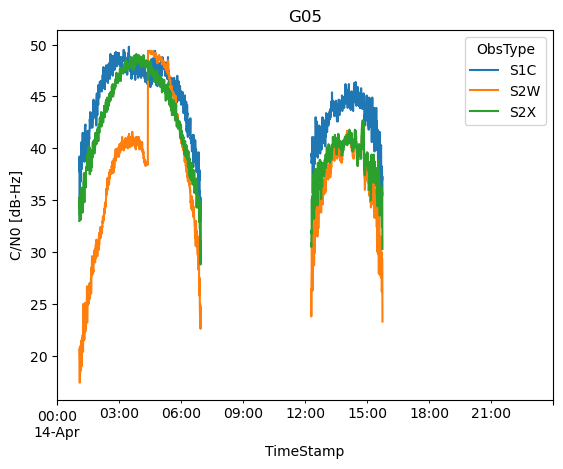

In [16]:
ax=gpsDf['G05'][['S1C', 'S2W', 'S2X']].plot()
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('G05');

**If you get an `Key Error` then you specified either a satellite that is not in the dataset or an observation type that is unavailable for the selected satellite. Remember this when you select your own datasets.**

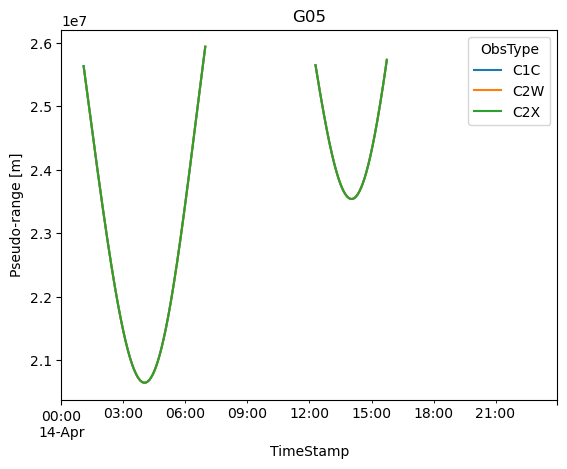

In [17]:
ax=gpsDf['G05'][['C1C', 'C2W', 'C2X']].plot()
ax.set_ylabel('Pseudo-range [m]')
ax.set_title('G05');

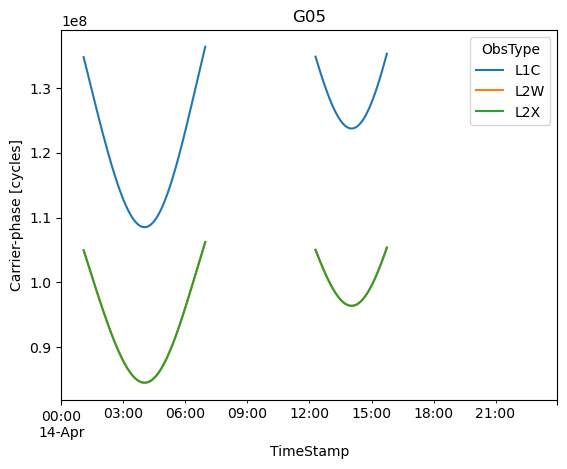

In [19]:
ax=gpsDf['G05'][['L1C', 'L2W', 'L2X']].plot()
ax.set_ylabel('Carrier-phase [cycles]')
ax.set_title('G05');

To do more advanced selection use the `.loc()` method.

Same as gpsDf['G05'][['S1C', 'S2W', 'S2X']].plot()


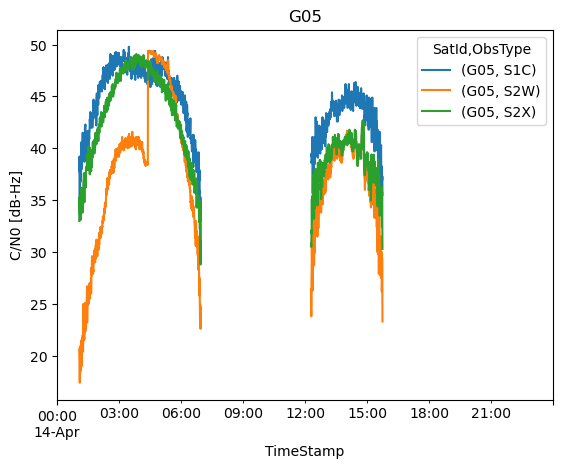

In [19]:
ax=gpsDf.loc(axis=1)['G05',['S1C', 'S2W', 'S2X']].plot()
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('G05');
print("Same as gpsDf['G05'][['S1C', 'S2W', 'S2X']].plot()")



Two satellites, notice that G02 has no L2C (S2X)


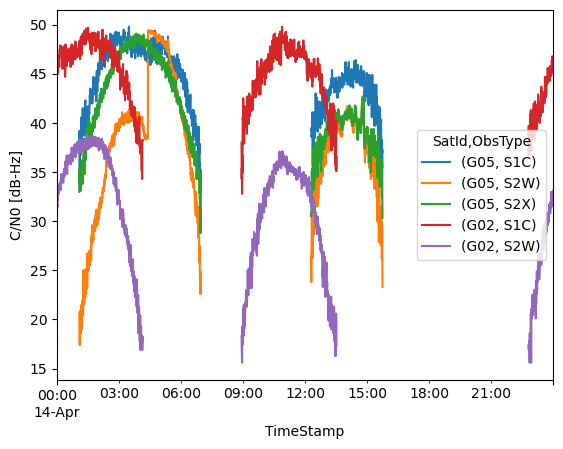

In [20]:
ax=gpsDf.loc(axis=1)[['G05', 'G02'],['S1C', 'S2W', 'S2X']].plot()
ax.set_ylabel('C/N0 [dB-Hz]')
print("Two satellites, notice that G02 has no L2C (S2X)")

All satellites with S2X


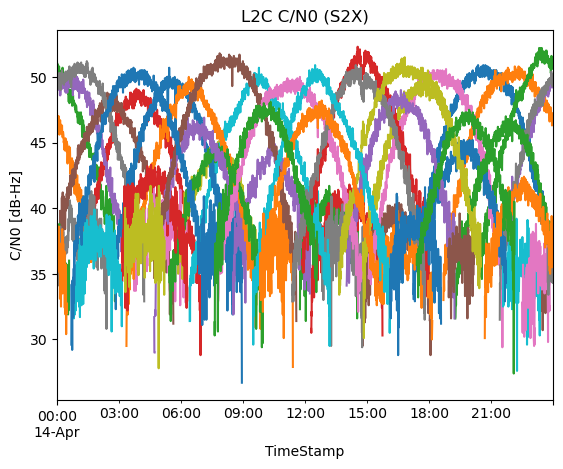

In [21]:
ax=gpsDf.loc(axis=1)[:,'S2X'].plot(legend=None)
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('L2C C/N0 (S2X)')
print("All satellites with S2X")

Start and end times are easy to specify

In [22]:
tfirst=pd.Timestamp('2021-04-14 11:00')
tlast=pd.Timestamp('2021-04-14 13:00')

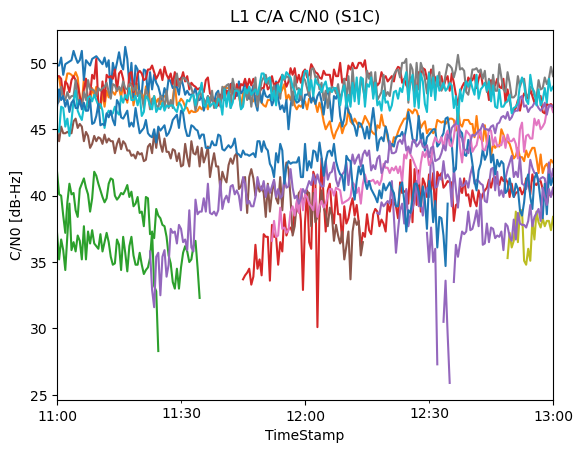

In [23]:
ax=gpsDf.loc(axis=0)[tfirst:tlast].loc(axis=1)[:,'S1C'].plot(legend=None)
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('L1 C/A C/N0 (S1C)');

You are not limited to time series plot. Sometimes it is even better to use the stacked DataFrame instead of the unstacked DataFrame. For example, to investigate the relation between the carrier-to-noise ratios you can do something like this.

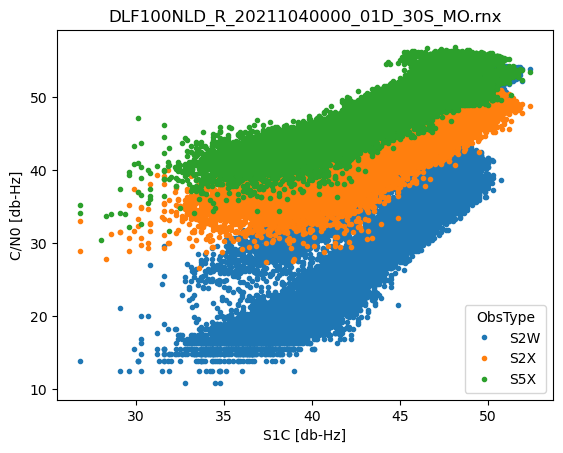

In [25]:
ax = gpsDf_stacked.plot(x='S1C', y=['S2W', 'S2X', 'S5X'], style='.')

ax.set_title(gpsDf_stacked.attrs['rnxFilename'])
ax.set_xlabel('S1C [db-Hz]')
ax.set_ylabel('C/N0 [db-Hz]');
#ax.axes.set_aspect('equal');

# Part 2: taking differences of observations

Let's repeat two of the plots of the pseudo-range and carrier-phase observations.

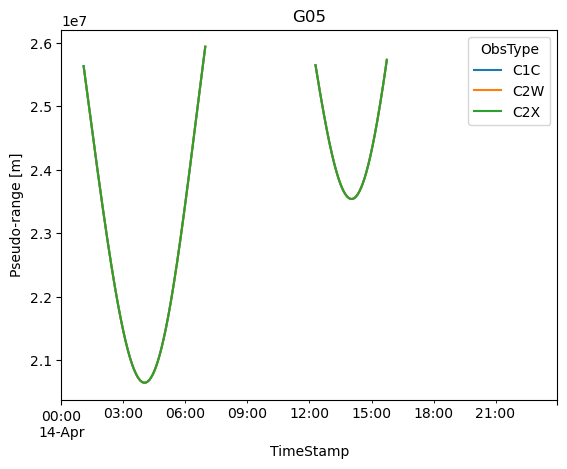

In [31]:
ax=gpsDf['G05'][['C1C', 'C2W', 'C2X']].plot()
ax.set_ylabel('Pseudo-range [m]')
ax.set_title('G05');

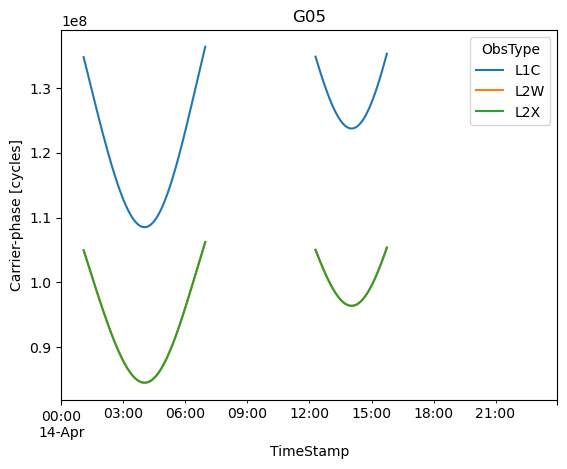

In [32]:
ax=gpsDf['G05'][['L1C', 'L2W', 'L2X']].plot()
ax.set_ylabel('Carrier-phase [cycles]')
ax.set_title('G05');

In the plot of the three pseudo-ranges (`C__`), which have units of meters, all signals are plotted over each other and look like a single curve. For the carrier phase (`L__`), which have units of cycles, plots are not overlaid for different frequencies and because of **arbitrary** initial phase ambiguities.

In order to see the differences we have two task at hand

* Multiply the carrier-phase with the wavelength of the signal (to obtain units of meters)
* Take differences between signals to actually see what the differences are

For the first task we need the frequency of the signals, which we will deal with later.

We start with taking differences (simple linear combinations) of the pseudo-ranges for which we don't need the frequencies.

## Differences between observations types

You can do ordinary math on pandas DataFrames as long as you respect the rules of `numpy` and Python. Meaning, `*` and `/` is element wise multiplication and division, and `@` is shorthand for matrix multiplication.

To take the difference between `C2W` and `C1C` for GPS `G05`, and plotting, is as simple as

In [33]:
lc = gpsDf['G05']['C2W'] - gpsDf['G05']['C1C']
print(lc.dropna(how='all'))
print(type(lc))

TimeStamp
2021-04-14 01:05:00    5.438
2021-04-14 01:05:30    3.949
2021-04-14 01:06:00    4.816
2021-04-14 01:06:30    4.890
2021-04-14 01:07:00    4.379
                       ...  
2021-04-14 15:42:30    5.500
2021-04-14 15:43:00    5.649
2021-04-14 15:43:30    6.860
2021-04-14 15:44:00    6.261
2021-04-14 15:44:30    5.973
Length: 1121, dtype: float64
<class 'pandas.core.series.Series'>


The result is a pandas Series object, which is the one dimensional equivalent of a pandas DataFrame, and ideal for plotting time series.

The `.dropna(how='all')` in the print statement is used to remove rows with all `NaN`'s. For plotting we want to leave the `NaN`'s in, because these generate a break in the line.

To plot the time series use the `.plot()` method

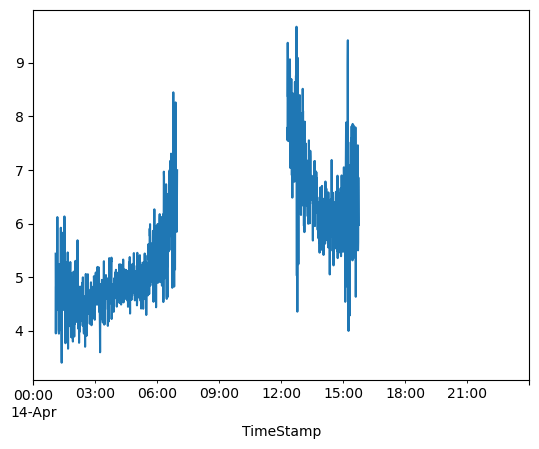

In [35]:
ax=lc.plot()
ax.set_title='G05'
ax.set_ylabel='C2W-C1C [m]'

Instead of taking explicit differences we can also use matrix multiplication. This is particularly useful for more complicated cases. We show two examples, the first gives the same result as above, the second computes all possible differences between the three pseudo-range observations.

<AxesSubplot:title={'center':'G05'}, xlabel='TimeStamp', ylabel='C2W-C1C [m]'>

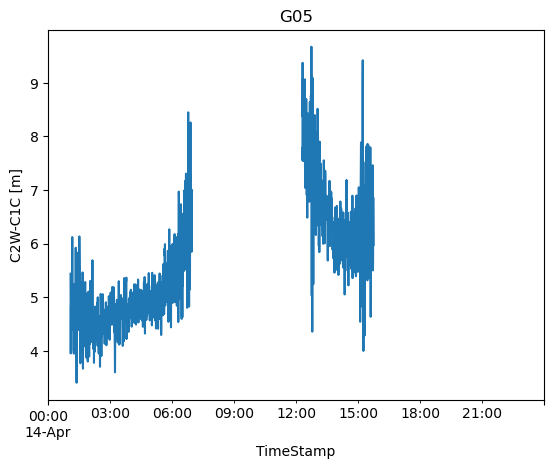

In [36]:
lc = gpsDf['G05'][['C1C', 'C2W']] @ np.array([ - 1, 1]).T
lc.plot(title='G05', ylabel='C2W-C1C [m]')

mmat= [[-1  1  0]
 [-1  0  1]
 [ 0 -1  1]]
                         0      1      2
TimeStamp                               
2021-04-14 01:05:00  5.438  5.488  0.050
2021-04-14 01:05:30  3.949  3.844 -0.105
2021-04-14 01:06:00  4.816  5.176  0.360
2021-04-14 01:06:30  4.890  4.480 -0.410
2021-04-14 01:07:00  4.379  3.480 -0.899
...                    ...    ...    ...
2021-04-14 15:42:30  5.500  5.675  0.175
2021-04-14 15:43:00  5.649  5.332 -0.317
2021-04-14 15:43:30  6.860  7.258  0.398
2021-04-14 15:44:00  6.261  6.562  0.301
2021-04-14 15:44:30  5.973  5.731 -0.242

[1121 rows x 3 columns]


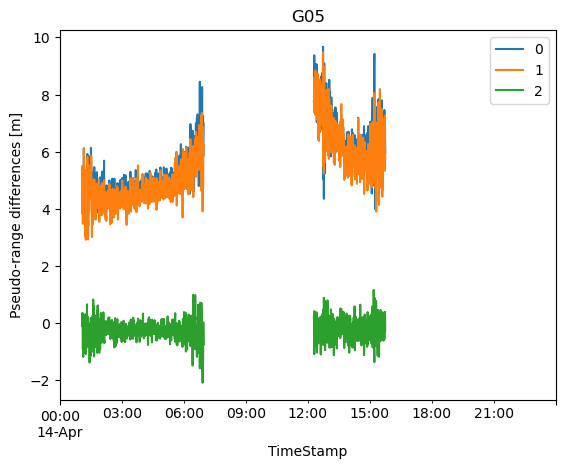

In [38]:
mmat = np.array([ [ -1, 1, 0 ], [ -1, 0, 1], [ 0, -1, 1] ])
print('mmat=',mmat)

lc = gpsDf['G05'][['C1C', 'C2W', 'C2X']] @ mmat.T

print(lc.dropna(how='all'))
ax=lc.plot(title='G05', ylabel='Pseudo-range differences [m]')

The second example requires some further work to get the legend correct. This is not a concern, because there is a third - more elegant - method. Instead of multiplying with a `numpy` matrix, we multiply with another pandas DataFrame, with all the labels correct.

In [39]:
LCmat = pd.DataFrame( [ [ -1, 1, 0 ], [ -1, 0, 1], [ 0, -1, 1] ],
            columns=['C1C', 'C2W', 'C2X'],
            index=['C2W-C1C', 'C2X-C1C', 'C2X-C2W'])
LCmat

,C1C,C2W,C2X
C2W-C1C,-1,1,0
C2X-C1C,-1,0,1
C2X-C2W,0,-1,1


The result of the multiplication is now a DataFrame with correct column names.

To put everything together and plot

<AxesSubplot:title={'center':'G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

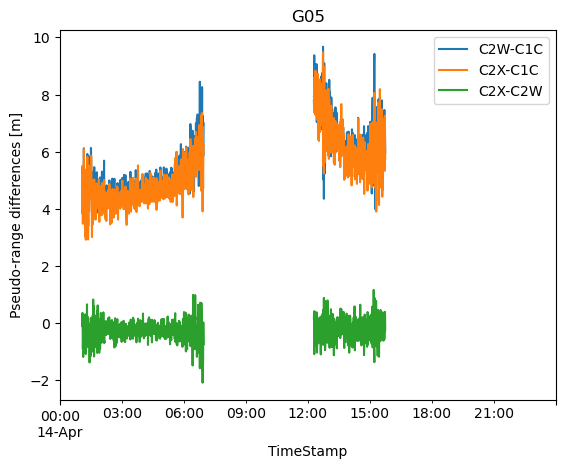

In [40]:
lc = gpsDf['G05'][['C1C', 'C2W', 'C2X']] @ LCmat.T
lc.plot(title='G05', ylabel='Pseudo-range differences [m]')

What you are actually seeing in the `C2X-C2W` is the pseudo-range and multipath error of both measurements, because the range and ionosphere delay are the same for both. The two other combinations, `C2_-C1C`, include also the difference in ionosphere delay between the L1 and L2 frequency (ionosphere delay is dispersive and proportional to the reciprocal of the frequency squared). 

[End of Notebook - last updated: April 2024]